# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = imresize(image, (120,120))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path + '/' + t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder+(num_batches*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = imresize(image, (120,120))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [37]:
# importing models required for model buiding
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Model 1: Conv3D Model 

In [9]:
#write your model here
model1 = Sequential()

model1.add(Conv3D(16, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,120,120,3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Conv3D(32, (3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(64, (3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(128, (3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(64,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()

model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_13 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
activation_9 (Activation)    (None, 18, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 9, 60, 120, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 60, 120, 32)    13856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 9, 60, 120, 32)    128       
_________________________________________________________________
activation_10 (Activation)   (None, 9, 60, 120, 32)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.`

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
def filepath_gen(model_name):
    model_name = model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    
    return filepath

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
# Plotting the history of model
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
def model_gen(filepath, model):
    filepath = filepath_gen(filepath)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
    callbacks_list = [checkpoint, LR]
    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                          callbacks=callbacks_list, validation_data=val_generator, 
                                          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history

In [28]:
model1_history = model_gen('model_conv3d1', model1)

Epoch 1/25
67/67 [==============================] - 46s 692ms/step - loss: 0.7664 - categorical_accuracy: 0.7110 - val_loss: 0.9584 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_conv3d1_2020-12-2006_23_33.477976/model-00001-0.74652-0.71493-0.95843-0.60000.h5
Epoch 2/25
67/67 [==============================] - 47s 707ms/step - loss: 0.6298 - categorical_accuracy: 0.7677 - val_loss: 0.8154 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_conv3d1_2020-12-2006_23_33.477976/model-00002-0.62147-0.77225-0.81537-0.69000.h5
Epoch 3/25
67/67 [==============================] - 46s 689ms/step - loss: 0.7977 - categorical_accuracy: 0.7121 - val_loss: 1.6963 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_conv3d1_2020-12-2006_23_33.477976/model-00003-0.73991-0.71946-1.69629-0.39000.h5
Epoch 4/25
67/67 [==============================] - 45s 670ms/step - loss: 0.6269 - categorical_accuracy: 0.7647 - val_loss: 1.0468 - val_categorica

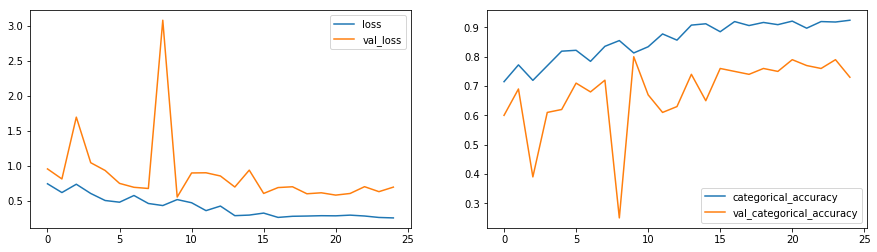

In [29]:
plot(model1_history)

**From the above plots, we can clearly see that the model is overfitting even after using dropouts.**
<br> So, we'll try to introduce learning rate to the optimiser.

### Model 2: Adding a Learning Rate to the optimiser in Model 1

In [30]:
model2 = Sequential()

model2.add(Conv3D(16, (3,3,3), padding='same', input_shape=(18,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, (3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 18, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 9, 60, 60, 32)     128       
_________________________________________________________________
activation_14 (Activation)   (None, 9, 60, 60, 32)     0         
__________

In [31]:
model2_history = model_gen('model_conv3d2', model2)

Epoch 1/25
67/67 [==============================] - 47s 699ms/step - loss: 1.7513 - categorical_accuracy: 0.3766 - val_loss: 1.4942 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_conv3d2_2020-12-2006_23_33.477976/model-00001-1.74194-0.37707-1.49419-0.43000.h5
Epoch 2/25
67/67 [==============================] - 43s 639ms/step - loss: 1.2792 - categorical_accuracy: 0.5050 - val_loss: 1.3076 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_conv3d2_2020-12-2006_23_33.477976/model-00002-1.27319-0.50679-1.30756-0.57000.h5
Epoch 3/25
67/67 [==============================] - 46s 683ms/step - loss: 1.2210 - categorical_accuracy: 0.5583 - val_loss: 1.3536 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_conv3d2_2020-12-2006_23_33.477976/model-00003-1.17782-0.56410-1.35364-0.50000.h5
Epoch 4/25
67/67 [==============================] - 45s 672ms/step - loss: 1.1400 - categorical_accuracy: 0.5553 - val_loss: 1.1014 - val_categorica

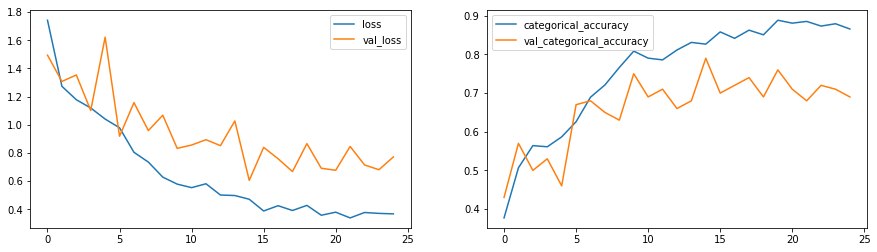

In [32]:
plot(model2_history)

**Even after introducing learning rate to the optimiser, we can see the model is overfitting.** <br>
We'll try reducing the number of parameters.

### Model 3: Reducing the number of parameters

In [33]:
model3 = Sequential()

model3.add(Conv3D(16, (3,3,3), padding='same', input_shape=(18,120,120,3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(32, (3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64, (2,2,2), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(128, (2,2,2), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))
        
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.25))

model3.add(BatchNormalization())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(5,activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_25 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
activation_17 (Activation)   (None, 18, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 9, 60, 60, 32)     128       
_________________________________________________________________
activation_18 (Activation)   (None, 9, 60, 60, 32)     0         
__________

In [34]:
model3_history = model_gen('model_conv3d3', model3)

Epoch 1/25
67/67 [==============================] - 46s 681ms/step - loss: 1.6056 - categorical_accuracy: 0.3303 - val_loss: 1.0613 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_conv3d3_2020-12-2006_23_33.477976/model-00001-1.60434-0.33032-1.06132-0.56000.h5
Epoch 2/25
67/67 [==============================] - 39s 588ms/step - loss: 1.2520 - categorical_accuracy: 0.4866 - val_loss: 0.9590 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_conv3d3_2020-12-2006_23_33.477976/model-00002-1.23523-0.49170-0.95902-0.60000.h5
Epoch 3/25
67/67 [==============================] - 41s 615ms/step - loss: 1.1046 - categorical_accuracy: 0.5687 - val_loss: 0.8715 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model to model_conv3d3_2020-12-2006_23_33.477976/model-00003-1.09170-0.57466-0.87153-0.71000.h5
Epoch 4/25
67/67 [==============================] - 43s 642ms/step - loss: 0.9410 - categorical_accuracy: 0.6423 - val_loss: 0.9267 - val_categorica

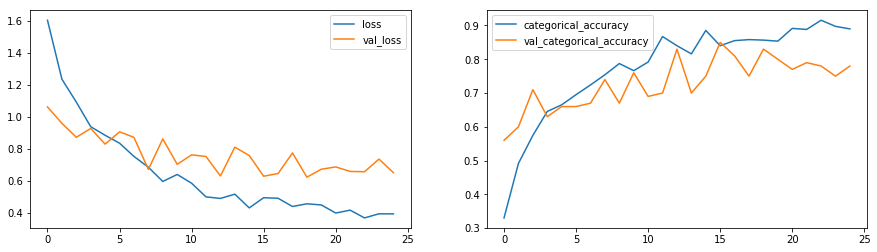

In [35]:
plot(model3_history)

**After reducing the number of parameters, the model is less overfitting compared to the previous models.**
<br>Next we'll try CNN + RNN models.

### Model 4: CNN-LSTM

In [38]:
from keras.layers.recurrent import LSTM

model4 = Sequential()
model4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(18,120,120,3)))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))
model4.add(LSTM(64))
model4.add(Dropout(0.25))
        
model4.add(Dense(64,activation='relu'))
model4.add(Dropout(0.25))
        
model4.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [39]:
model4_history = model_gen('model_cnnlstm', model4)

Epoch 1/25
67/67 [==============================] - 47s 708ms/step - loss: 1.5615 - categorical_accuracy: 0.2926 - val_loss: 1.4121 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_cnnlstm_2020-12-2006_23_33.477976/model-00001-1.56000-0.29563-1.41208-0.45000.h5
Epoch 2/25
67/67 [==============================] - 42s 627ms/step - loss: 1.4182 - categorical_accuracy: 0.3662 - val_loss: 1.6457 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_cnnlstm_2020-12-2006_23_33.477976/model-00002-1.41842-0.36652-1.64566-0.21000.h5
Epoch 3/25
67/67 [==============================] - 45s 666ms/step - loss: 1.4404 - categorical_accuracy: 0.3632 - val_loss: 1.5387 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_cnnlstm_2020-12-2006_23_33.477976/model-00003-1.43576-0.36350-1.53873-0.29000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
67/67 [==============================] - 45s 672ms/step 

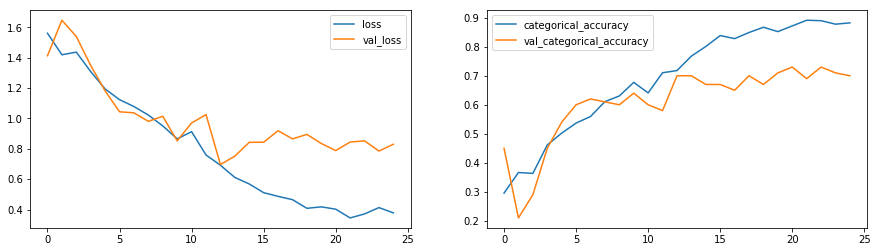

In [40]:
plot(model4_history)

**The CNN-LSTM model also tends to overfit the given data.**
<br> At last, we'll try transfer learning using mobilenet.

### Model 5: Transfer Learning with GRU 

In [41]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model5 = Sequential()
model5.add(TimeDistributed(mobilenet_transfer, input_shape=(18,120,120,3)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))
model5.add(GRU(64))
model5.add(Dropout(0.25))
        
model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.25))
        
model5.add(Dense(5, activation='softmax'))
        
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model5.summary())

17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (D

In [42]:
model5_history = model_gen('model_mnet', model5)

Epoch 1/25
67/67 [==============================] - 56s 843ms/step - loss: 1.2087 - categorical_accuracy: 0.5080 - val_loss: 0.6190 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to model_mnet_2020-12-2006_23_33.477976/model-00001-1.19435-0.50980-0.61900-0.70000.h5
Epoch 2/25
67/67 [==============================] - 44s 649ms/step - loss: 0.7013 - categorical_accuracy: 0.7210 - val_loss: 0.6554 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_mnet_2020-12-2006_23_33.477976/model-00002-0.67582-0.72851-0.65537-0.62000.h5
Epoch 3/25
67/67 [==============================] - 43s 647ms/step - loss: 0.6918 - categorical_accuracy: 0.7404 - val_loss: 0.4988 - val_categorical_accuracy: 0.7900

Epoch 00003: saving model to model_mnet_2020-12-2006_23_33.477976/model-00003-0.64239-0.74811-0.49877-0.79000.h5
Epoch 4/25
67/67 [==============================] - 43s 648ms/step - loss: 0.5089 - categorical_accuracy: 0.8006 - val_loss: 0.4970 - val_categorical_accurac

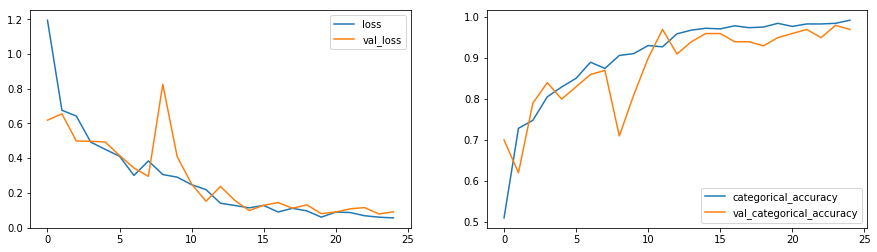

In [43]:
plot(model5_history)

**The transfer learning model has produced the best results for the given data.**

### Observation
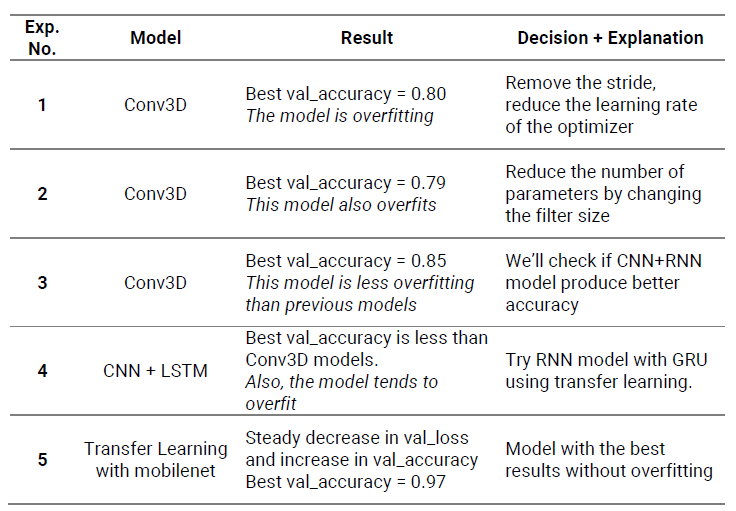

_Case Study by **Salaj sinha & Arushi shree**_